In [3]:
install.packages("tidyverse")

also installing the dependencies 'colorspace', 'sys', 'bit', 'ps', 'sass', 'cachem', 'farver', 'labeling', 'munsell', 'RColorBrewer', 'viridisLite', 'rappdirs', 'rematch', 'askpass', 'bit64', 'prettyunits', 'processx', 'highr', 'xfun', 'yaml', 'bslib', 'fontawesome', 'jquerylib', 'tinytex', 'backports', 'generics', 'memoise', 'blob', 'DBI', 'R6', 'tidyselect', 'withr', 'data.table', 'gtable', 'isoband', 'scales', 'gargle', 'cellranger', 'curl', 'ids', 'rematch2', 'cpp11', 'pkgconfig', 'mime', 'openssl', 'timechange', 'systemfonts', 'textshaping', 'clipr', 'vroom', 'tzdb', 'progress', 'callr', 'fs', 'knitr', 'rmarkdown', 'selectr', 'stringi', 'broom', 'conflicted', 'dbplyr', 'dplyr', 'dtplyr', 'forcats', 'ggplot2', 'googledrive', 'googlesheets4', 'haven', 'hms', 'httr', 'lubridate', 'magrittr', 'modelr', 'purrr', 'ragg', 'readr', 'readxl', 'reprex', 'rstudioapi', 'rvest', 'stringr', 'tibble', 'tidyr', 'xml2'




package 'colorspace' successfully unpacked and MD5 sums checked
package 'sys' successfully unpacked and MD5 sums checked
package 'bit' successfully unpacked and MD5 sums checked
package 'ps' successfully unpacked and MD5 sums checked
package 'sass' successfully unpacked and MD5 sums checked
package 'cachem' successfully unpacked and MD5 sums checked
package 'farver' successfully unpacked and MD5 sums checked
package 'labeling' successfully unpacked and MD5 sums checked
package 'munsell' successfully unpacked and MD5 sums checked
package 'RColorBrewer' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'rappdirs' successfully unpacked and MD5 sums checked
package 'rematch' successfully unpacked and MD5 sums checked
package 'askpass' successfully unpacked and MD5 sums checked
package 'bit64' successfully unpacked and MD5 sums checked
package 'prettyunits' successfully unpacked and MD5 sums checked
package 'processx' success

In [7]:
# Importing necessary libraries
library("tidyverse")
library("ggplot2")
library("ggrepel")
library("ggcorrplot")
library("DT")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in library("ggrepel"): there is no package called 'ggrepel'


# Dataset : COVID-19_cases_plus_census (updated)

In [193]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

In [194]:
#filter the dataset by Texas
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")

In [195]:
# First 10 rows
head(dataset_plus_census)

,state,state_fips_code,county_name,confirmed_cases,deaths,total_pop,male_pop,female_pop,white_pop,black_pop,⋯,male_21_49,male_50_above,female_0_20,female_21_49,female_50_above,unemployed_pop,employed_pop,commute,worked_at_home,walked_to_work
,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,TX,48,Hansford County,673,17,5532,2760,2772,2950,4,⋯,1052,922,858,1053,979,94,2394,4384,18,70
2,TX,48,Stonewall County,134,4,1084,555,529,787,38,⋯,113,325,129,112,306,11,442,836,7,0
3,TX,48,Cochran County,216,12,2932,1492,1440,1104,77,⋯,418,536,420,538,548,103,1189,2274,23,12
4,TX,48,Crockett County,472,13,3836,1903,1933,1264,35,⋯,512,748,584,662,738,43,1733,3346,60,0
5,TX,48,McCulloch County,467,12,8145,4171,3974,5067,161,⋯,1354,1765,911,1334,1885,122,3658,6566,61,104
6,TX,48,Sherman County,118,11,3067,1590,1477,1712,8,⋯,582,594,398,577,555,24,1604,2930,38,72


In [196]:
# Checking for missing values
sum(is.na(dataset_plus_census))

[1] 0

In [197]:
# Basic statistics
summary(dataset_plus_census)

    state           state_fips_code county_name        confirmed_cases 
 Length:254         Min.   :48      Length:254         Min.   :     1  
 Class :character   1st Qu.:48      Class :character   1st Qu.:   487  
 Mode  :character   Median :48      Mode  :character   Median :  1310  
                    Mean   :48                         Mean   :  8419  
                    3rd Qu.:48                         3rd Qu.:  3502  
                    Max.   :48                         Max.   :286356  
     deaths          total_pop          male_pop         female_pop     
 Min.   :   0.00   Min.   :     74   Min.   :     39   Min.   :     35  
 1st Qu.:  13.00   1st Qu.:   7072   1st Qu.:   3632   1st Qu.:   3134  
 Median :  30.00   Median :  18612   Median :   9472   Median :   9139  
 Mean   : 127.48   Mean   : 107951   Mean   :  53610   Mean   :  54341  
 3rd Qu.:  78.75   3rd Qu.:  49295   3rd Qu.:  25014   3rd Qu.:  24443  
 Max.   :3825.00   Max.   :4525519   Max.   :2251060   Max

## Scale the data

In [80]:
# Prepare data
dataset_cases_TX_clustering <- dataset_cases_TX %>%
  select(county_name, confirmed_cases)

In [82]:
# internal structure of the dataset
str (dataset_plus_census)

'data.frame':	254 obs. of  33 variables:
 $ state                : chr  "TX" "TX" "TX" "TX" ...
 $ state_fips_code      : int  48 48 48 48 48 48 48 48 48 48 ...
 $ county_name          : chr  "Hansford County" "Stonewall County" "Cochran County" "Crockett County" ...
 $ confirmed_cases      : int  673 134 216 472 467 118 11 114 1475 176 ...
 $ deaths               : int  17 4 12 13 12 11 0 3 46 7 ...
 $ total_pop            : int  5532 1084 2932 3836 8145 3067 289 1591 12755 1498 ...
 $ male_pop             : int  2760 555 1492 1903 4171 1590 150 796 6753 758 ...
 $ female_pop           : int  2772 529 1440 1933 3974 1477 139 795 6002 740 ...
 $ white_pop            : int  2950 787 1104 1264 5067 1712 212 964 5203 803 ...
 $ black_pop            : int  4 38 77 35 161 8 0 27 592 153 ...
 $ asian_pop            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hispanic_pop         : int  2569 246 1672 2537 2571 1327 77 513 6858 490 ...
 $ amerindian_pop       : int  6 0 6 0 1 7 0 0 31 5 ...
 $ other_rac

In [94]:
# Remove county from county names and convert them to lower case
dataset_cases_TX_clustering <- dataset_cases_TX_clustering %>% 
    mutate(county_name = tolower(gsub(" County", "", county_name)))

length(unique(dataset_cases_TX_clustering$county_name))

[1] 254

There are 254 unique Texas counties in the dataset.

## Chosen Variables

We looked at all of the 31 feature variables that could be correlated to confirmed cases or deaths in project 1. Based on the observations made, following were the variables that seem to be highly correlated with confirmed cases.
- Race
- Income range
- Age group

Therefore, these variables are chosen to peform various types of cluster analysis.

In [96]:
# Basic statistics of the chosen variables
summary(dataset_plus_census %>% select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop,
                                  income_less_50K, income_50K_100K, income_100K_150K, income_150K_more,
                                  male_0_20, male_21_49, male_50_above, female_0_20, female_21_49, female_50_above))

   white_pop         black_pop          asian_pop          hispanic_pop    
 Min.   :     55   Min.   :     0.0   Min.   :     0.00   Min.   :     12  
 1st Qu.:   2856   1st Qu.:    95.2   1st Qu.:    11.25   1st Qu.:   1654  
 Median :   9404   Median :   676.0   Median :    73.50   Median :   5068  
 Mean   :  46282   Mean   : 12594.6   Mean   :  4814.86   Mean   :  42023  
 3rd Qu.:  31433   3rd Qu.:  3708.5   3rd Qu.:   384.25   3rd Qu.:  13815  
 Max.   :1386576   Max.   :838285.0   Max.   :307109.00   Max.   :1910535  
 amerindian_pop   other_race_pop   income_less_50K  income_50K_100K   
 Min.   :   0.0   Min.   :   0.0   Min.   :     9   Min.   :    19.0  
 1st Qu.:   6.0   1st Qu.:   0.0   1st Qu.:  1234   1st Qu.:   685.8  
 Median :  41.0   Median :   2.5   Median :  3348   Median :  1968.5  
 Mean   : 259.4   Mean   : 154.1   Mean   : 16364   Mean   : 11096.8  
 3rd Qu.: 162.2   3rd Qu.:  35.0   3rd Qu.:  9082   3rd Qu.:  5140.0  
 Max.   :8078.0   Max.   :9681.0   Max.   

## K-means (Euclidean distance) for variables related to Race

### Clustering Tendency (Hopkins Statistic)

In [127]:
# Installing hopkins package
install.packages("hopkins")

also installing the dependencies 'donut', 'pdist', 'RANN'




package 'donut' successfully unpacked and MD5 sums checked
package 'pdist' successfully unpacked and MD5 sums checked
package 'RANN' successfully unpacked and MD5 sums checked
package 'hopkins' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\RtmpikTSpN\downloaded_packages


In [128]:
library(hopkins)


Attaching package: 'hopkins'


The following object is masked from 'package:clustertend':

    hopkins




In [130]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat <- hopkins(dataset_plus_census_scaled_race)
hopkins_stat

[1] 0.9997677

This shows that there is a strong clustering tendency.

In [198]:
# Prepare the dataset
dataset_plus_census_scaled_race <- dataset_plus_census %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, other_race_pop) %>% 
  scale() %>% as_tibble()

# Scale the confirmed_cases column for K-means
dataset_plus_census_scaled_race_scaled <- scale(dataset_plus_census_scaled_race)

In [199]:
summary(dataset_plus_census_scaled_race)

   white_pop         black_pop         asian_pop        hispanic_pop    
 Min.   :-0.3380   Min.   :-0.1860   Min.   :-0.1859   Min.   :-0.2440  
 1st Qu.:-0.3175   1st Qu.:-0.1846   1st Qu.:-0.1854   1st Qu.:-0.2344  
 Median :-0.2696   Median :-0.1760   Median :-0.1830   Median :-0.2146  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.1086   3rd Qu.:-0.1312   3rd Qu.:-0.1710   3rd Qu.:-0.1638  
 Max.   : 9.7996   Max.   :12.1921   Max.   :11.6697   Max.   :10.8502  
 amerindian_pop    other_race_pop   
 Min.   :-0.3382   Min.   :-0.2027  
 1st Qu.:-0.3304   1st Qu.:-0.2027  
 Median :-0.2847   Median :-0.1994  
 Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.1266   3rd Qu.:-0.1567  
 Max.   :10.1944   Max.   :12.5278  

### Average Silhouette Width

In [140]:
install.packages("factoextra")
library(cluster)
library(factoextra)

also installing the dependencies 'Deriv', 'microbenchmark', 'doBy', 'SparseM', 'MatrixModels', 'minqa', 'nloptr', 'RcppEigen', 'later', 'lazyeval', 'carData', 'Formula', 'pbkrtest', 'quantreg', 'lme4', 'htmlwidgets', 'httpuv', 'crosstalk', 'promises', 'estimability', 'numDeriv', 'mvtnorm', 'corrplot', 'viridis', 'car', 'DT', 'ellipse', 'emmeans', 'flashClust', 'leaps', 'multcompView', 'scatterplot3d', 'ggsci', 'cowplot', 'ggsignif', 'gridExtra', 'polynom', 'rstatix', 'plyr', 'Rcpp', 'abind', 'dendextend', 'FactoMineR', 'ggpubr', 'reshape2', 'ggrepel'




package 'Deriv' successfully unpacked and MD5 sums checked
package 'microbenchmark' successfully unpacked and MD5 sums checked
package 'doBy' successfully unpacked and MD5 sums checked
package 'SparseM' successfully unpacked and MD5 sums checked
package 'MatrixModels' successfully unpacked and MD5 sums checked
package 'minqa' successfully unpacked and MD5 sums checked
package 'nloptr' successfully unpacked and MD5 sums checked
package 'RcppEigen' successfully unpacked and MD5 sums checked
package 'later' successfully unpacked and MD5 sums checked
package 'lazyeval' successfully unpacked and MD5 sums checked
package 'carData' successfully unpacked and MD5 sums checked
package 'Formula' successfully unpacked and MD5 sums checked
package 'pbkrtest' successfully unpacked and MD5 sums checked
package 'quantreg' successfully unpacked and MD5 sums checked
package 'lme4' successfully unpacked and MD5 sums checked
package 'htmlwidgets' successfully unpacked and MD5 sums checked
package 'httpuv'

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



[1] 2


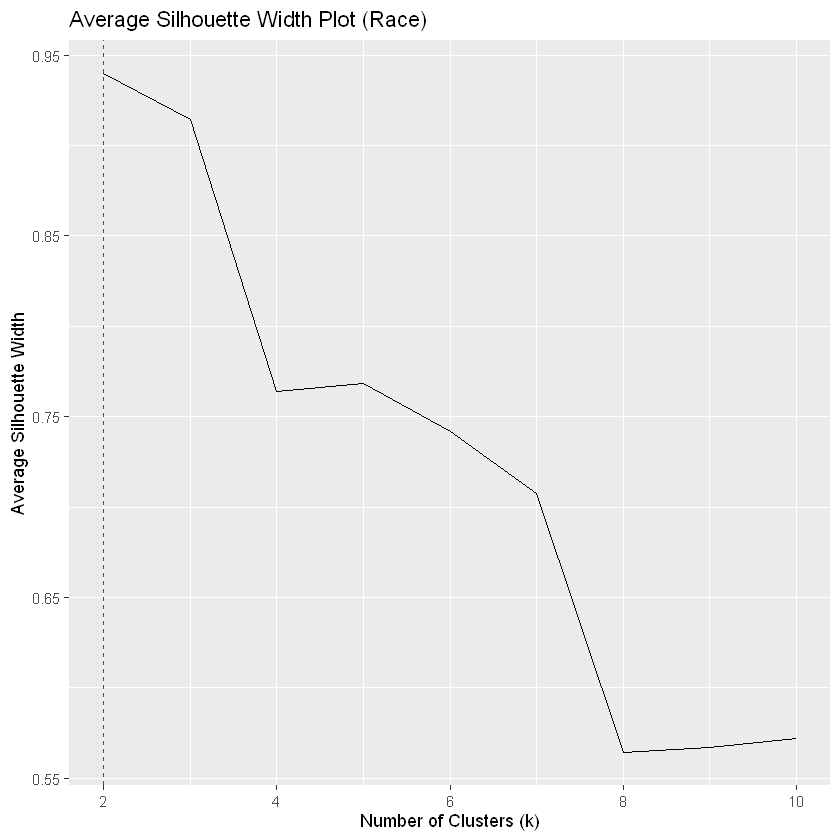

In [200]:
# range for number of clusters
ks_race <- 2:10

# Average Silhouette Width
ASW_race <- sapply(ks_race, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_race, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_race)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_race <- ks_race[which.max(ASW_race)]
print(best_k_race)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_race, ASW_race), aes(x = ks_race, y = ASW_race)) + 
  geom_line() +
  geom_vline(xintercept = best_k_race, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Race)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

  cluster size ave.sil.width
1       1  250          0.95
2       2    4          0.22


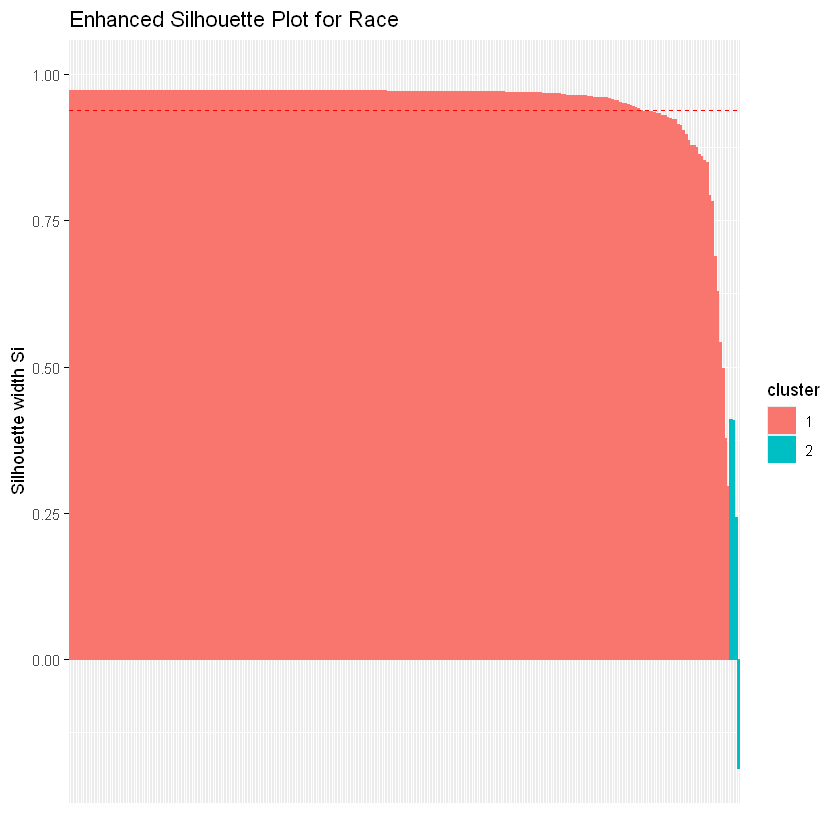

In [201]:
# K-means clustering (10 random restarts)
k_means_race <- kmeans(dataset_plus_census_scaled_race, centers=2, nstart = 10)

# distance for race
d_race <- dist(dataset_plus_census_scaled_race)

# Compute silhouette scores
sil_race <- silhouette(k_means_race$cluster, d_race)

# Basic silhouette plot
par(mfrow = c(1, 2))  # Set up the plotting area for side-by-side

# Enhanced silhouette plot using factoextra
fviz_silhouette(sil_race) + ggtitle("Enhanced Silhouette Plot for Race")

### Elbow Method: Within-Cluster Sum of Square

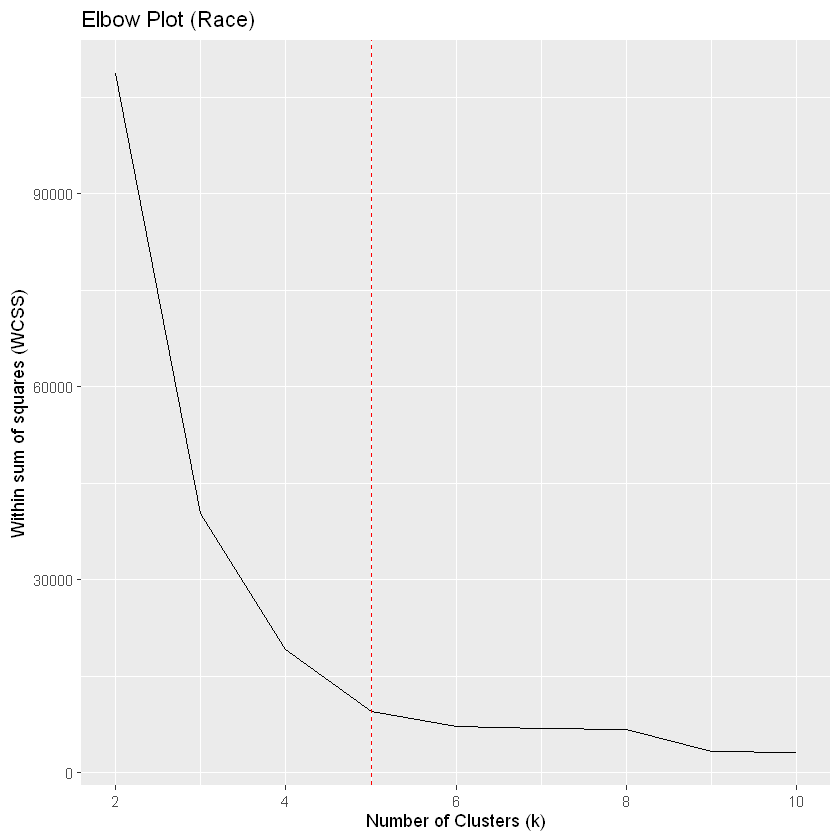

In [202]:
# use the same range of K 
#set.seed(1234)

#Calculate within-cluster sum of squares for number of clusters
WCSS_race <- sapply(ks_race, FUN = function(k) {
  kmeans(d_race <- dist(dataset_plus_census_scaled_race), centers = k, nstart = 10)$tot.withinss
  })

# Plot 
ggplot(tibble(ks_race, WCSS_race), aes(ks_race, WCSS_race)) + 
  geom_line() +
  geom_vline(xintercept = 5, color = "red", linetype = 2)+
  ggtitle("Elbow Plot (Race)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")

This indicates that after 9 clusters, the within sum of squares seem to remain unchanged.

### Gap Statistic

Warning message:
"did not converge in 10 iterations"


Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_race, FUNcluster = kmeans, K.max = 20, nstart = 10)
B=100 simulated reference sets, k = 1..20; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.344533 6.493346 2.148813 0.02574588
 [2,] 3.996593 5.980371 1.983778 0.01895153
 [3,] 3.757887 5.755606 1.997719 0.01511626
 [4,] 3.515578 5.635034 2.119456 0.01553402
 [5,] 3.394511 5.559640 2.165128 0.01327055
 [6,] 3.242851 5.510520 2.267669 0.01258617
 [7,] 3.116279 5.469174 2.352894 0.01303596
 [8,] 3.030583 5.431049 2.400466 0.01361448
 [9,] 2.929574 5.396742 2.467168 0.01443299
[10,] 2.852691 5.364578 2.511887 0.01522306
[11,] 2.794372 5.334971 2.540599 0.01508347
[12,] 2.753443 5.307551 2.554109 0.01412619
[13,] 2.701312 5.282153 2.580841 0.01489745
[14,] 2.666295 5.259996 2.593701 0.01477243
[15,] 2.623518 5.238074 2.614556 0.01413328
[16,] 2.591399 5.216177 2.624778

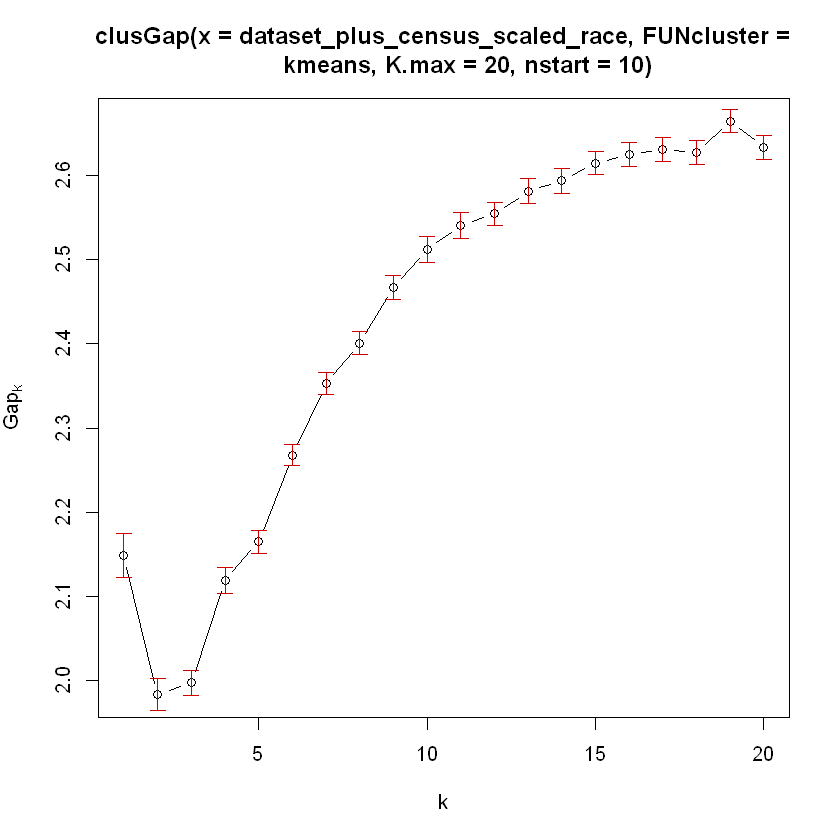

In [204]:
k_race_gap <- clusGap(dataset_plus_census_scaled_race, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 20)
k_race_gap

plot(k_race_gap)

Although, the elbow seem to suggest more than 2 clusters is what we need for the dataset, the gap statistic and Silhouette Width analysis indicate that 2 clusters is enough to distinctly define the dataset. There is sufficient separation among the data points in those two clusters.

### Inspect the clusters

In [205]:
cluster_profile_race <- ggplot(pivot_longer(as_tibble(k_means_race$centers,  rownames = "cluster"), 
  cols = colnames(k_means_race$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (Race)") + 
  guides(fill="none")

#Save teh profile
ggsave("cluster_profile_race.png", plot = cluster_profile_race, width = 6, height = 2)

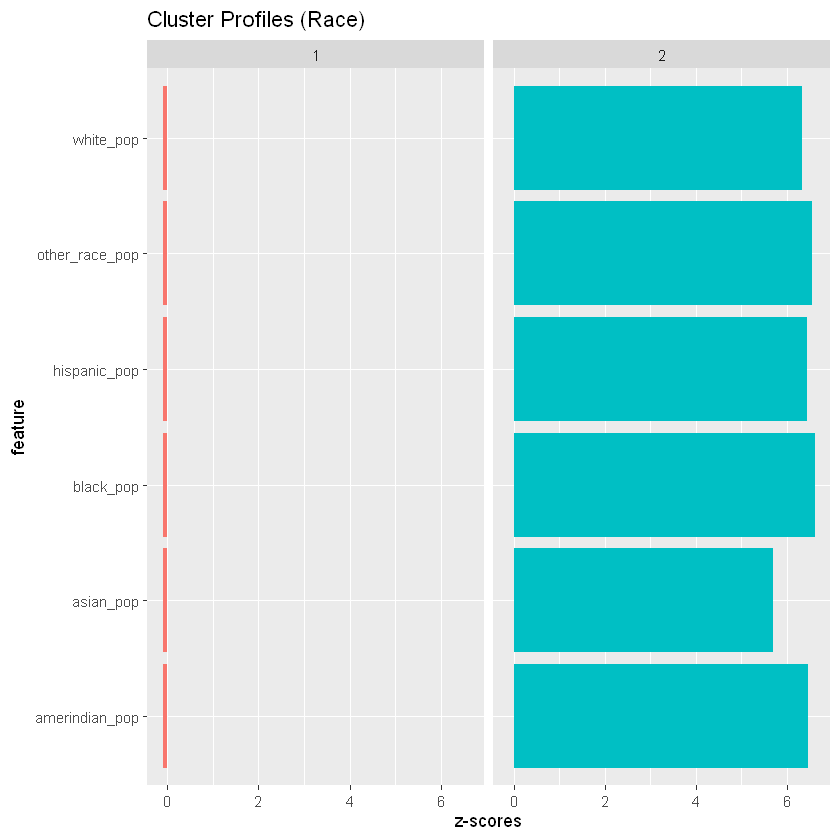

In [206]:
cluster_profile_race

In [207]:
k_means_race

K-means clustering with 2 clusters of sizes 250, 4

Cluster means:
   white_pop  black_pop   asian_pop hispanic_pop amerindian_pop other_race_pop
1 -0.1014624 -0.1058965 -0.09113562   -0.1032176     -0.1032634     -0.1048446
2  6.3413973  6.6185312  5.69597638    6.4511009      6.4539599      6.5527855

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 287.5953 244.1868
 (between_SS / total_SS =  65.0 %)

Available components:

[1

Cluster 1: High values for all racial population features (e.g., white_pop, black_pop, asian_pop, etc.), indicating that this cluster represents a group with higher populations across these features.  
Cluster 2: All mean values close to zero, indicating that this cluster represents a group with average population figures across the racial demographics.  
The ratio of between_SS to total_SS is 65.0%, suggesting that the clustering structure explains a significant portion of the variability in the data.  
Given that the first cluster has distinctly different characteristics compared to the second and that we see a clear separation in terms of average feature values, it is reasonable to conclude that two clusters are sufficient to define the dataset. The compactness and separation of the clusters suggest that they represent meaningful segments of your data.

### Supervised Evaluation

In [239]:
# Pick median_income feature as the ground truth

# Convert the median incomes into 3 categories (low is <50K, medium is 51-100K, and high 100K above)
dataset_plus_census <- dataset_plus_census %>%
  mutate(income_category = cut(median_income, 
                               breaks = c(-Inf, 50000, 100000, Inf), 
                               labels = c("low", "medium", "high"), 
                               include.lowest = TRUE))

# Extract ground truth labels
ground_truth <- dataset_plus_census$income_category

#### Purity

In [242]:
# Purity function
purity <- function(cluster, truth, show_table = FALSE) {
  if (length(cluster) != length(truth))
    stop("Cluster vector and ground truth vectors are not of the same length!")
  
  tbl <- table(cluster, truth)
  if(show_table)
    print(tbl)
  
  majority <- apply(tbl, 1, max)
  sum(majority) / length(cluster)
}

# K-means clustering  (2, 4, and 6 clusters)
k_means_race_2 <- kmeans(dataset_plus_census_scaled_race, centers=2, nstart = 10)
k_means_race_4 <- kmeans(dataset_plus_census_scaled_race, centers=4, nstart = 10)


#compute purity metrics
purity_score_race_2 <- purity(k_means_race_2$cluster, ground_truth, show_table = TRUE)
purity_score_race_4 <- purity(k_means_race_4$cluster, ground_truth, show_table = TRUE)

# Comparison
compare_race_clusterings <- rbind(
    truth = c(unlist(fpc::cluster.stats(d_race, as.numeric(ground_truth), as.numeric(ground_truth), compareonly = TRUE)),
              purity = purity(as.numeric(ground_truth), as.numeric(ground_truth))),

    k_means_race_2 = c(unlist(fpc::cluster.stats(d_race, k_means_race_2$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_race_2$cluster, as.numeric(ground_truth))),
  
  k_means_race_4 = c(unlist(fpc::cluster.stats(d_race, k_means_race_4$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_race_4$cluster, as.numeric(ground_truth))))
     
# Print the comparison results
print(compare_race_clusterings)

       truth
cluster low medium high
      1 147    103    0
      2   0      4    0
       truth
cluster low medium high
      1  10     11    0
      2 137     88    0
      3   0      7    0
      4   0      1    0
               corrected.rand        vi    purity
truth              1.00000000 0.0000000 1.0000000
k_means_race_2     0.01250452 0.7341141 0.5944882
k_means_race_4     0.03568737 1.0536654 0.6141732


## K-means (Euclidean distance) for variables related to income levels

In [224]:
# Prepare the dataset
dataset_plus_census_income <- dataset_plus_census %>% 
  select(income_less_50K, income_50K_100K, income_100K_150K, income_150K_more) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_income_scaled <- scale(dataset_plus_census_income)

In [225]:
head(dataset_plus_census_income_scaled)

income_less_50K,income_50K_100K,income_100K_150K,income_150K_more
-0.2601184,-0.2658357,-0.2651707,-0.2344314
-0.2759289,-0.2741831,-0.2715483,-0.2391374
-0.2696834,-0.2712590,-0.2693346,-0.2381637
-0.2686568,-0.2661606,-0.2614813,-0.2382719
-0.2503138,-0.2530148,-0.2589514,-0.2336200
-0.2717196,-0.2688098,-0.2659613,-0.2370819


In [226]:
summary(dataset_plus_census_income_scaled)

 income_less_50K   income_50K_100K   income_100K_150K  income_150K_more 
 Min.   :-0.2798   Min.   :-0.2769   Min.   :-0.2742   Min.   :-0.2415  
 1st Qu.:-0.2589   1st Qu.:-0.2602   1st Qu.:-0.2623   1st Qu.:-0.2341  
 Median :-0.2227   Median :-0.2281   Median :-0.2355   Median :-0.2196  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.1246   3rd Qu.:-0.1489   3rd Qu.:-0.1635   3rd Qu.:-0.1744  
 Max.   :11.3614   Max.   :11.0425   Max.   :11.0368   Max.   :11.3841  

Mean is 0 for all columns. Min and max is similar to all columns. So scaling is good.

### Clustering Tendency (Hopkins Statistic)

In [227]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_income <- hopkins(dataset_plus_census_income_scaled)
hopkins_stat_income

[1] 0.9999871

This shows that there is a strong clustering tendency.

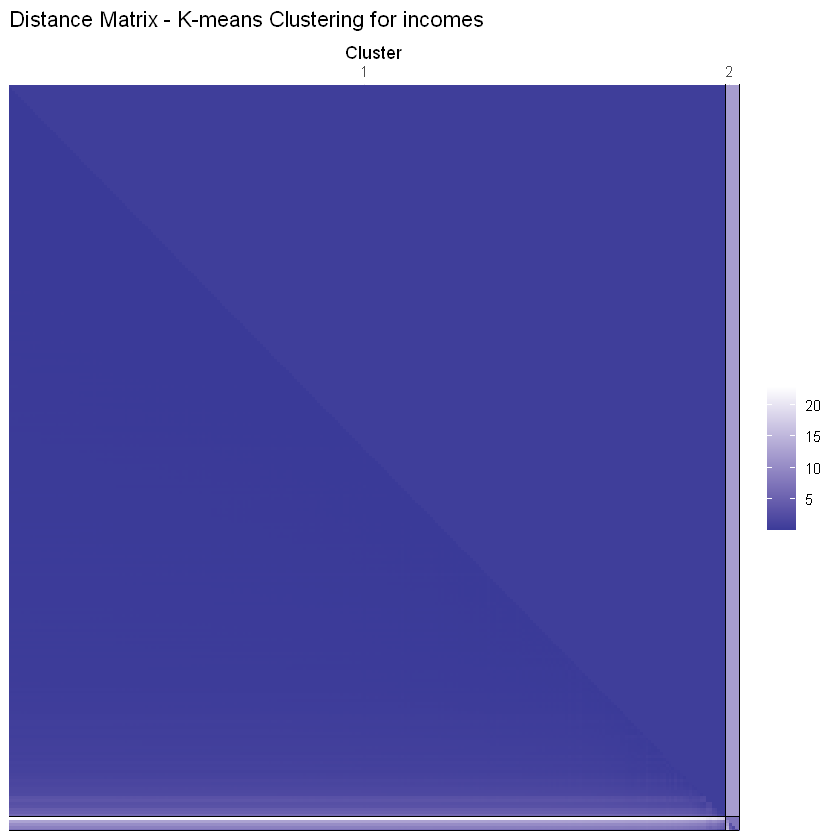

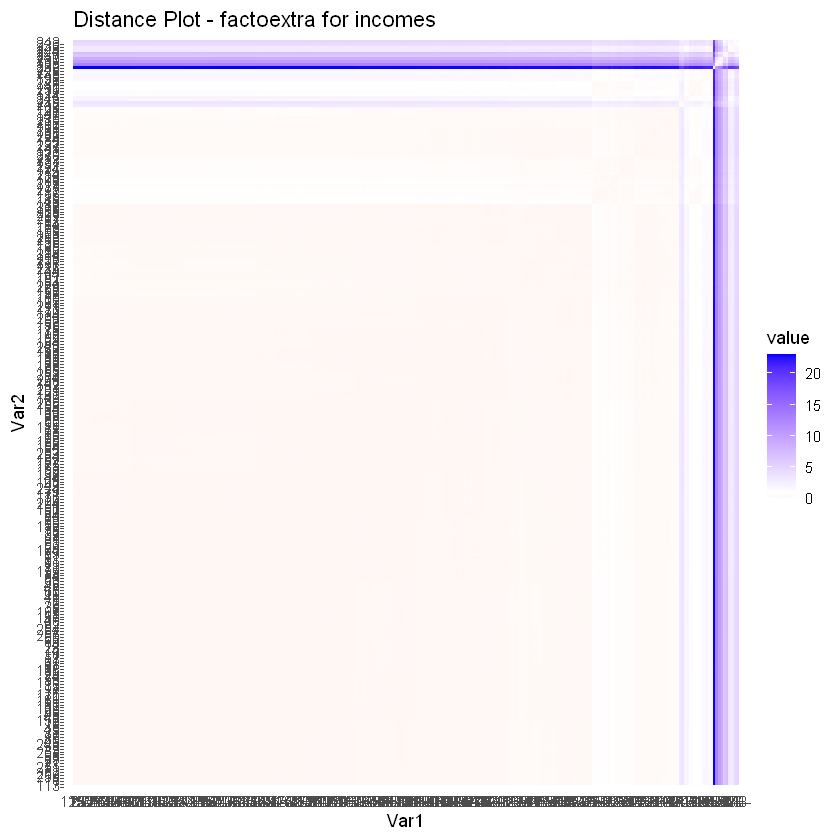

In [228]:
# K-means clustering (10 random restarts)
k_means_income <- kmeans(dataset_plus_census_income_scaled, centers=2, nstart = 10)

# distance for incomes
d_income <- dist(dataset_plus_census_income_scaled)

# Create ggdissplot
diss_plot_incomes <- ggdissplot(d_income, labels = k_means_income$cluster) +
  ggtitle("Distance Matrix - K-means Clustering for incomes") +
  theme_minimal()

# Create factoextra plot
fviz_plot_incomes <- fviz_dist(d_income) +
  ggtitle("Distance Plot - factoextra for incomes") +
  theme_minimal()

diss_plot_incomes
fviz_plot_incomes

Looking at the plots, it looks like 2 clusters are enough.

### Average Silhouette Width

[1] 2

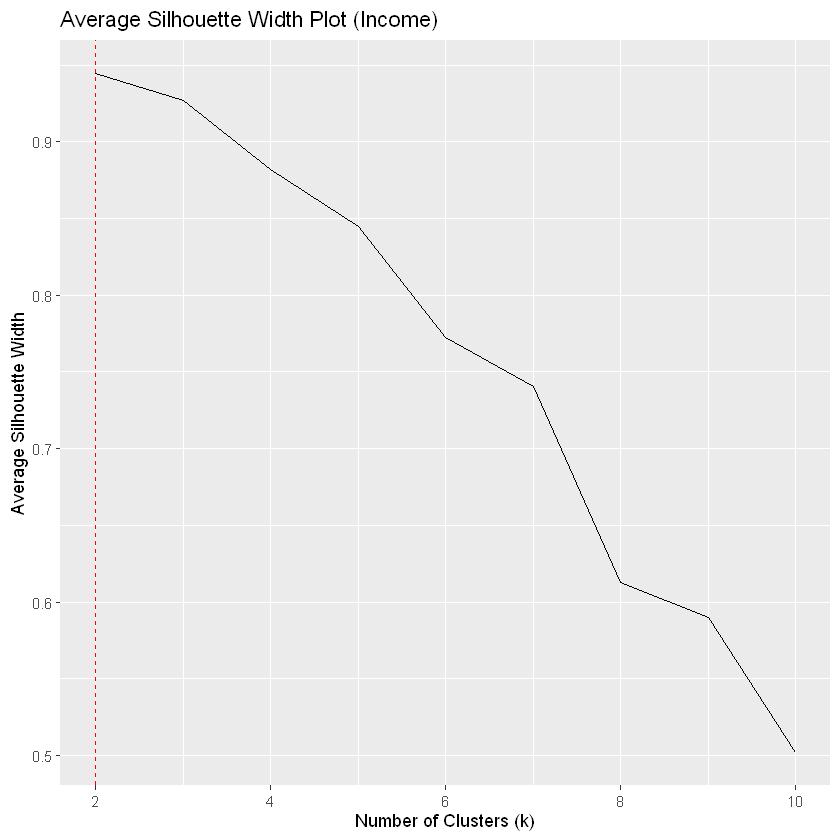

In [229]:
# range for number of clusters
ks_income <- 2:10

# Average Silhouette Width
ASW_income <- sapply(ks_income, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_income_scaled, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_income)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_income <- ks_income[which.max(ASW_income)]
best_k_income

# Plot the Average Silhouette Width
ggplot(data.frame(ks_income, ASW_income), aes(x = ks_income, y = ASW_income)) + 
  geom_line() +
  geom_vline(xintercept = best_k_income, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Income)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

  cluster size ave.sil.width
1       1  249          0.96
2       2    5          0.34


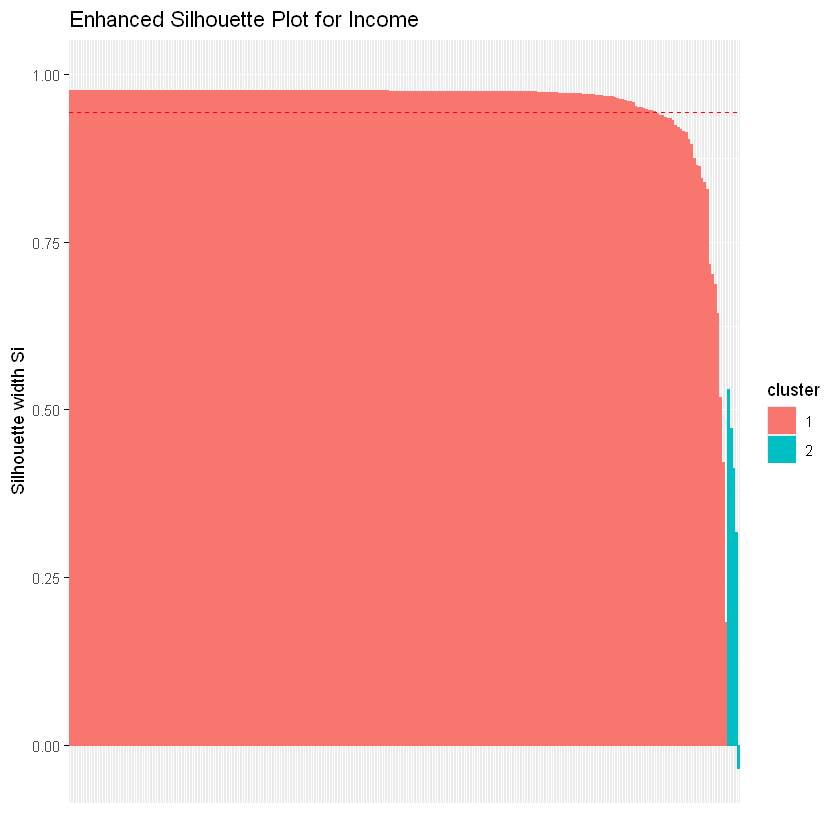

In [230]:
# K-means clustering (10 random restarts)
k_means_income <- kmeans(dataset_plus_census_income_scaled, centers=2, nstart = 10)

# Compute silhouette scores
sil_income <- silhouette(k_means_income$cluster, d_income)

# Enhanced silhouette plot using factoextra
fviz_silhouette(sil_income) + ggtitle("Enhanced Silhouette Plot for Income")

## K-means (Euclidean distance) for variables related to age ranges for both genders

In [223]:
# Prepare the dataset
dataset_plus_census_age <- dataset_plus_census %>% 
  select(male_0_20, male_21_49, male_50_above, female_0_20, female_21_49, female_50_above) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_age_scaled <- scale(dataset_plus_census_age)

head(dataset_plus_census_age_scaled)

male_0_20,male_21_49,male_50_above,female_0_20,female_21_49,female_50_above
-0.2612117,-0.2523913,-0.2860831,-0.2590497,-0.2488105,-0.2855535
-0.2723111,-0.2637618,-0.2974268,-0.2714028,-0.2602491,-0.2969196
-0.2652257,-0.2600685,-0.2934176,-0.2664717,-0.2550707,-0.2928325
-0.2633731,-0.2589302,-0.2893893,-0.2636927,-0.2535634,-0.2896236
-0.2558814,-0.2487343,-0.2700652,-0.2581516,-0.2453947,-0.2702523
-0.2672570,-0.2580826,-0.2923155,-0.2668445,-0.2545966,-0.2927143


In [231]:
summary(dataset_plus_census_age_scaled)

   male_0_20         male_21_49      male_50_above      female_0_20     
 Min.   :-0.2747   Min.   :-0.2650   Min.   :-0.3031   Min.   :-0.2735  
 1st Qu.:-0.2585   1st Qu.:-0.2504   1st Qu.:-0.2811   1st Qu.:-0.2581  
 Median :-0.2318   Median :-0.2235   Median :-0.2351   Median :-0.2338  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.1576   3rd Qu.:-0.1535   3rd Qu.:-0.1252   3rd Qu.:-0.1558  
 Max.   :11.3659   Max.   :11.5120   Max.   :11.1878   Max.   :11.3428  
  female_21_49     female_50_above  
 Min.   :-0.2615   Min.   :-0.3017  
 1st Qu.:-0.2488   1st Qu.:-0.2807  
 Median :-0.2269   Median :-0.2368  
 Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:-0.1599   3rd Qu.:-0.1337  
 Max.   :11.3846   Max.   :11.0158  

### Clustering Tendency (Hopkins Statistic)

In [232]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_age <- hopkins(dataset_plus_census_age_scaled)
hopkins_stat_age

[1] 1

This shows that there is a strong clustering tendency.

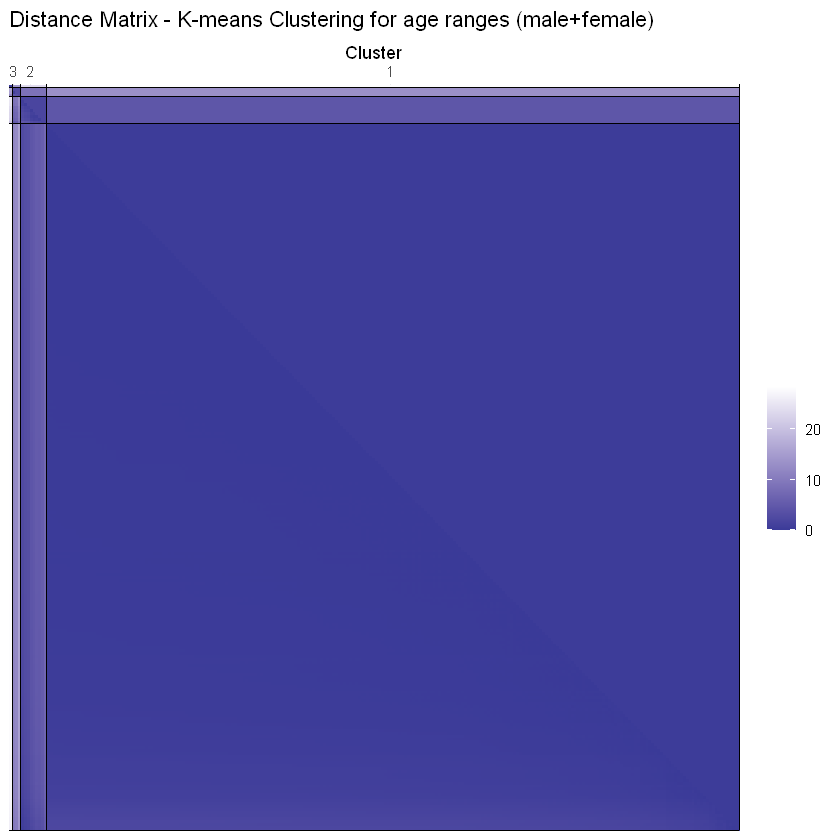

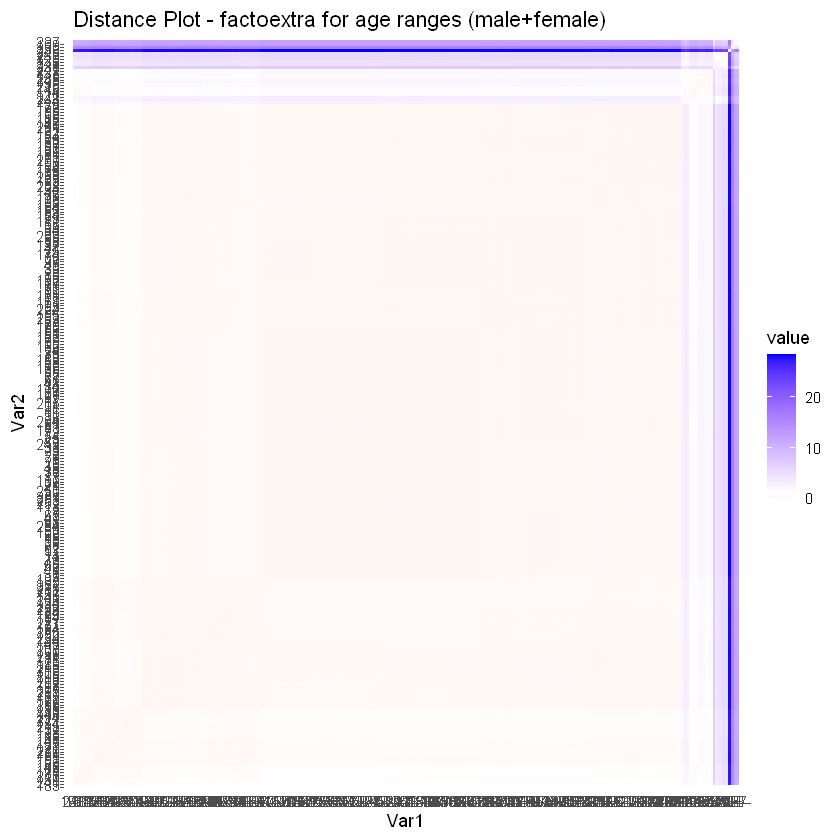

In [235]:
# K-means clustering (10 random restarts)
k_means_age <- kmeans(dataset_plus_census_age_scaled, centers=4, nstart = 10)

# distance for incomes
d_age <- dist(dataset_plus_census_age_scaled)

# Create ggdissplot
diss_plot_age <- ggdissplot(d_age, labels = k_means_age$cluster) +
  ggtitle("Distance Matrix - K-means Clustering for age ranges (male+female)") +
  theme_minimal()

# Create factoextra plot
fviz_plot_age <- fviz_dist(d_age) +
  ggtitle("Distance Plot - factoextra for age ranges (male+female)") +
  theme_minimal()

diss_plot_age
fviz_plot_age

Looking at the plots, it looks like 4 clusters are enough.

### Average Silhouette Width

Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"


[1] 2

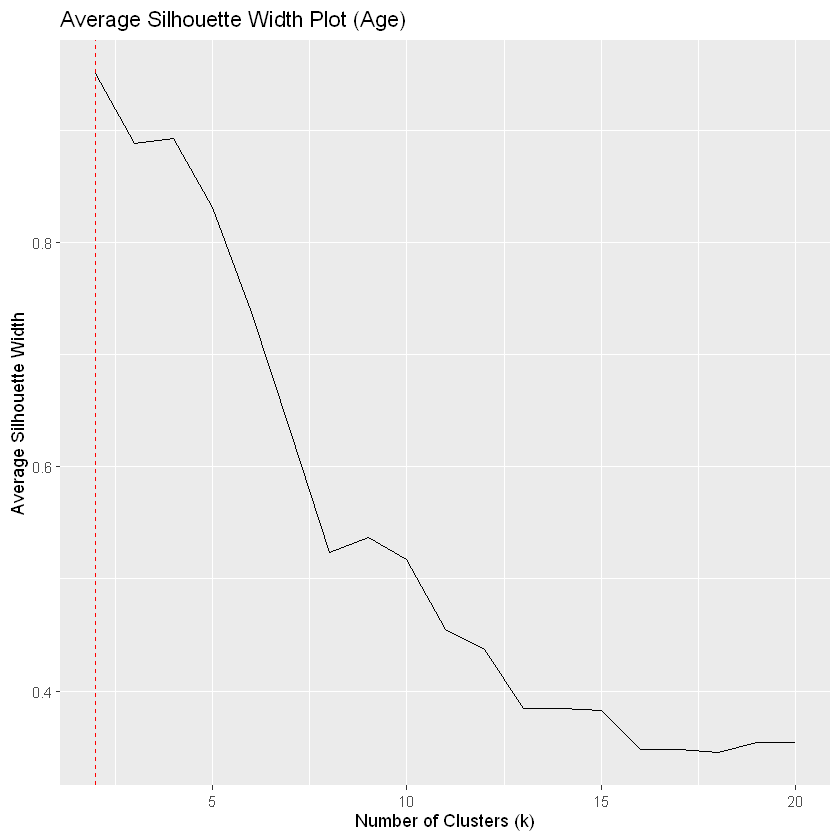

In [237]:
# range for number of clusters
ks_age <- 2:20

# Average Silhouette Width
ASW_age <- sapply(ks_age, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_age_scaled, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_age)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# best k
best_k_age <- ks_age[which.max(ASW_age)]
best_k_age

# Plot the Average Silhouette Width
ggplot(data.frame(ks_age, ASW_age), aes(x = ks_age, y = ASW_age)) + 
  geom_line() +
  geom_vline(xintercept = best_k_age, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Age)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")

  cluster size ave.sil.width
1       1    9          0.54
2       2    1          0.00
3       3  241          0.91
4       4    3          0.69


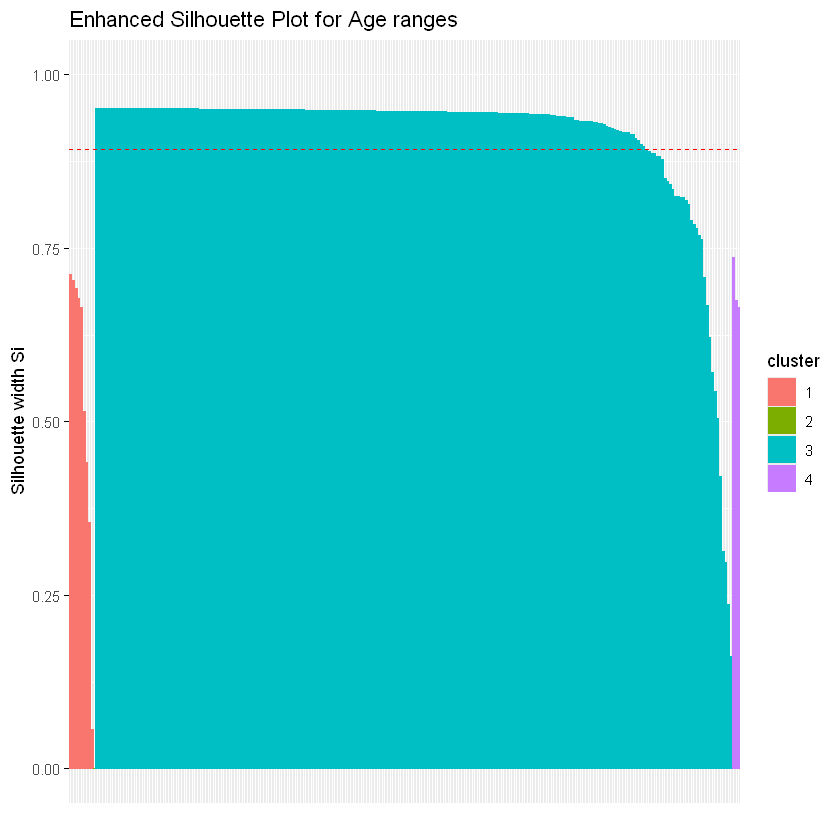

In [238]:
# K-means clustering (10 random restarts)
k_means_age <- kmeans(dataset_plus_census_age_scaled, centers=4, nstart = 10)

# Compute silhouette scores
sil_age <- silhouette(k_means_age$cluster, d_age)

# Enhanced silhouette plot using factoextra
fviz_silhouette(sil_age) + ggtitle("Enhanced Silhouette Plot for Age ranges")

## Third Clustering

## Fourth Clustering